In [1]:
#ipynb config
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.cross_validation import train_test_split
from models.face_trigger import FaceTrigger
from utils.visualizer import Visualizer
from IPython.display import SVG, display

import numpy as np
import matplotlib.pyplot as plt

import os
import cv2
import time
import pydot
import pickle
import lasagne
import itertools

plt.style.use('ggplot')

%matplotlib inline

Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5005)


In [3]:
def get_hex_color(layer_type):
    """
    Determines the hex color for a layer.
    :parameters:
        - layer_type : string
            Class name of the layer
    :returns:
        - color : string containing a hex color for filling block.
    """
    COLORS = ['#4A88B3', '#98C1DE', '#6CA2C8', '#3173A2', '#17649B',
              '#FFBB60', '#FFDAA9', '#FFC981', '#FCAC41', '#F29416',
              '#C54AAA', '#E698D4', '#D56CBE', '#B72F99', '#B0108D',
              '#75DF54', '#B3F1A0', '#91E875', '#5DD637', '#3FCD12']

    hashed = int(hash(layer_type)) % 5

    if "conv" in layer_type.lower():
        return COLORS[:5][hashed]
    if layer_type in lasagne.layers.pool.__all__:
        return COLORS[5:10][hashed]
    if layer_type in lasagne.layers.recurrent.__all__:
        return COLORS[10:15][hashed]
    else:
        return COLORS[15:20][hashed]

def make_pydot_graph(layers, output_shape=True, verbose=False):
    """
    :parameters:
        - layers : list
            List of the layers, as obtained from lasagne.layers.get_all_layers
        - output_shape: (default `True`)
            If `True`, the output shape of each layer will be displayed.
        - verbose: (default `False`)
            If `True`, layer attributes like filter shape, stride, etc.
            will be displayed.
    :returns:
        - pydot_graph : PyDot object containing the graph
    """

    pydot_graph = pydot.Dot('Network', graph_type='digraph')
    pydot_nodes = {}
    pydot_edges = []
    for i, layer in enumerate(layers):
        layer_type = '{0}'.format(layer.__class__.__name__)
        layer_name = layer.name if layer.name is not None else ''
        key = repr(layer)
        label = layer_name + ' ' + layer_type
        color = get_hex_color(layer_type)
        if verbose:
            for attr in ['num_filters', 'num_units', 'ds',
                         'filter_shape', 'stride', 'strides', 'p']:
                if hasattr(layer, attr):
                    label += '\n{0}: {1}'.format(attr, getattr(layer, attr))
            if hasattr(layer, 'nonlinearity'):
                try:
                    nonlinearity = layer.nonlinearity.__name__
                except AttributeError:
                    nonlinearity = layer.nonlinearity.__class__.__name__
                label += '\nnonlinearity: {0}'.format(nonlinearity)

        if output_shape:
            label += '\nOutput shape: {0}'.format(layer.output_shape)

        pydot_nodes[key] = pydot.Node(
            key, label=label, shape='record', fillcolor=color, style='filled')

        if hasattr(layer, 'input_layers'):
            for input_layer in layer.input_layers:
                pydot_edges.append([repr(input_layer), key])

        if hasattr(layer, 'input_layer'):
            pydot_edges.append([repr(layer.input_layer), key])

    for node in pydot_nodes.values():
        pydot_graph.add_node(node)

    for edges in pydot_edges:
        pydot_graph.add_edge(
            pydot.Edge(pydot_nodes[edges[0]], pydot_nodes[edges[1]]))
    return pydot_graph

def iterate_minibatches(inputs, targets, batch_size):
    indices = np.arange(len(inputs))
    np.random.shuffle(indices)
    
    for start_idx in range(0, len(inputs) - batch_size + 1, batch_size):
        excerpt = indices[start_idx:start_idx + batch_size]

        yield inputs[excerpt], targets[excerpt]


def learn(nn,
          dataset,
          watches=['obj',
                   'recall',
                   'precision',
                   'accuracy',
                   'loss',
                   'sub_loss'],
          num_epochs=100,
          batch_size=50):
    '''
        num_epochs - amount of passes through the data
        batch_size - number of samples processed at each function call
        dataset - [X_train, X_val, y_train, y_val]
    '''
    %matplotlib notebook
    
    X_train, X_val, y_train, y_val = dataset
    metrics_template = dict()
    
    metrics_sample = nn.evaluate(X_val[:2], y_val[:2])
    
    for metric_name, _ in metrics_sample.items():
        if metric_name == 'complexity_parts':
            metrics_template[metric_name] = [0] * len(metrics_sample[metric_name])
        else:
            metrics_template[metric_name] = 0
        
    visualizer = Visualizer(num_epochs,
                            metrics_template,
                            watches=watches)
    
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        start_time = time.time()
        
        train_measurements = dict(metrics_template)
        train_batches = 0

        for batch in iterate_minibatches(X_train, y_train, batch_size):
            inputs, targets = batch
            
            for metric_name, metric in nn.train(inputs, targets).items():
                if metric_name == 'complexity_parts':
                    for j in range(len(metrics_template[metric_name])):
                        train_measurements[metric_name][j] += metric[j]
                else: 
                    train_measurements[metric_name] += metric

            train_batches += 1
            
        for metric_name, metric in train_measurements.items():
            if metric_name == 'complexity_parts':
                for j in range(len(metrics_template[metric_name])):
                    train_measurements[metric_name][j] = metric[j] / train_batches
            else: 
                train_measurements[metric_name] = metric / train_batches

        # And a full pass over the validation data:
        val_measurements = dict(metrics_template)
        val_batches = 0

        for batch in iterate_minibatches(X_val, y_val, batch_size):
            inputs, targets = batch
            
            for metric_name, metric in nn.evaluate(inputs, targets).items():
                if metric_name == 'complexity_parts':
                    for j in range(len(metrics_template[metric_name])):
                        val_measurements[metric_name][j] += metric[j]
                else: 
                    val_measurements[metric_name] += metric

            val_batches += 1
            
        for metric_name, metric in val_measurements.items():
            if metric_name == 'complexity_parts':
                for j in range(len(metrics_template[metric_name])):
                    val_measurements[metric_name][j] = metric[j] / val_batches
            else: 
                val_measurements[metric_name] = metric / val_batches

        print('Epoch {} of {} took {:.3f}s'.format(epoch + 1, num_epochs, time.time() - start_time))
        visualizer.watch(train_measurements, val_measurements)
    visualizer.finish()
    
def draw(network):
    with open('../images/net.svg', 'w') as f:
        g = make_pydot_graph(lasagne.layers.get_all_layers(network))
        f.write(g.create_svg(f='svg'))

    display(SVG(filename='../images/net.svg'))

In [ ]:
faces_path = '../data/faces'
folds_path = os.path.join(faces_path, 'FDDB-folds')
dataset = {}
target = {}

for fold_name in os.listdir(folds_path):
    if 'ellipseList' not in fold_name:
        if fold_name not in dataset:
            dataset[fold_name] = []
            
        with open(os.path.join(folds_path, fold_name)) as f:
            for line in f:
                im = cv2.imread(os.path.join(faces_path, line.strip() + '.jpg'))
                dataset[fold_name].append(cv2.cvtColor(im, cv2.COLOR_BGR2GRAY))
                
    else:
        if fold_name not in dataset:
            target[fold_name] = []
            
        with open(os.path.join(folds_path, fold_name)) as f:
            while True:
                try:
                    img_name = f.next().strip()
                    num_ellipses = int(f.next().strip())
                    
                    im = cv2.imread(os.path.join(faces_path, img_name + '.jpg'))
                    im_t = np.zeros_like(im)
                    
                    for i in range(num_ellipses):
                        major_axis_radius, minor_axis_radius, angle, center_x, center_y, _ = f.next().strip().split()

                        cv2.ellipse(im_t,
                                    (int(float(center_x)), int(float(center_y))),
                                    (int(float(minor_axis_radius)), int(float(major_axis_radius))),
                                    int(float(angle)),
                                    0, 360, (255, 255, 255), -1)
                    
                    target[fold_name].append(cv2.cvtColor(im_t, cv2.COLOR_BGR2GRAY) == 255)
                except StopIteration:
                    break

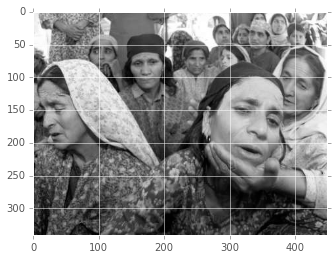

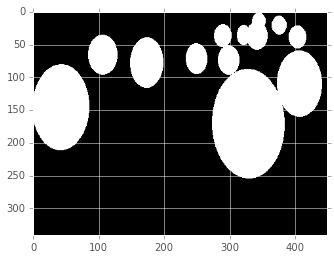

In [5]:
plt.imshow(dataset['FDDB-fold-03.txt'][0], cmap=plt.cm.gray)
plt.show()

plt.imshow(target['FDDB-fold-03-ellipseList.txt'][0], cmap=plt.cm.gray)
plt.show()

# Compile dataset

In [6]:
s = set()

for k, v in dataset.items():
    for im in v:
        s.add(im.shape)
        
shapes = np.array(list(s))
shape = shapes.max(axis=0)

In [7]:
def add_negative(im, pos_shape, negative):
    h1 = im.shape[0] - pos_shape[0]
    w1 = pos_shape[1]
    
    h2 = h1
    w2 = im.shape[1] - pos_shape[1]
    
    h3 = pos_shape[0]
    w3 = im.shape[1] - pos_shape[1]
    
    if h1 > 0 and w1 > 0:
        n = negative[np.random.choice(np.arange(len(negative)))]

        im[pos_shape[0]:pos_shape[0] + min([n.shape[0], h1]),
                       :               min([n.shape[1], w1])] = n[:min([n.shape[0], h1]),
                                                                  :min([n.shape[1], w1])]
        add_negative(im[pos_shape[0]:, :],
                     (min([n.shape[0], h1]), min([n.shape[1], w1])),
                     negative)
                     
    if h2 > 0 and w2 > 0:
        n = negative[np.random.choice(np.arange(len(negative)))]

        im[pos_shape[0]:pos_shape[0] + min([n.shape[0], h2]),
           pos_shape[1]:pos_shape[1] + min([n.shape[1], w2])] = n[:min([n.shape[0], h2]),
                                                                  :min([n.shape[1], w2])]
        add_negative(im[pos_shape[0]:pos_shape[0] + h2, pos_shape[1]:pos_shape[1] + w2],
                     (min([n.shape[0], h2]), min([n.shape[1], w2])),
                     negative)
                     
    if h3 > 0 and w3 > 0:
        n = negative[np.random.choice(np.arange(len(negative)))]

        im[            :min([n.shape[0], h3]),
           pos_shape[1]:pos_shape[1] + min([n.shape[1], w3])] = n[:min([n.shape[0], h3]),
                                                                  :min([n.shape[1], w3])]
        add_negative(im[:h3, pos_shape[1]:pos_shape[1] + w3],
                     (min([n.shape[0], h3]), min([n.shape[1], w3])),
                     negative)


def build_mosaic(shape, im, negative=None):
    moisaic = np.zeros(shape)
    moisaic[:im.shape[0], :im.shape[1]] = im
    
    if negative is not None:
        add_negative(moisaic, im.shape, negative)

    return moisaic

In [9]:
negative_path = '../data/256_ObjectCategories/'
negative = []

for d in os.listdir(negative_path):
    for im_name in os.listdir(os.path.join(negative_path, d)):
        im = cv2.imread(os.path.join(negative_path, d, im_name), 0)
        
        if im is not None:
            negative.append(im)
        
np.random.shuffle(negative)

In [10]:
mosaic_dataset = {}
mosaic_target = {}

for k, v in dataset.items():
    mosaic_dataset[k] = [None] * len(v)
    
    for i, im in enumerate(v):
        mosaic_dataset[k][i] = build_mosaic(shape, im, negative).astype(np.uint8)
        
for k, v in target.items():
    mosaic_target[k] = [None] * len(v)
    
    for i, im in enumerate(v):
        mosaic_target[k][i] = build_mosaic(shape, im).astype(np.uint8)

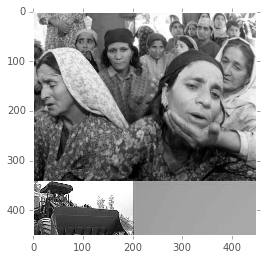

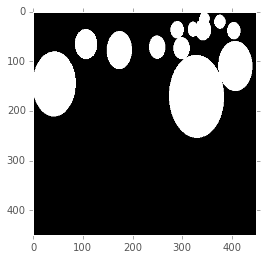

In [12]:
plt.imshow(mosaic_dataset.items()[0][1][0], cmap=plt.cm.gray)
plt.grid(False)
plt.show()

plt.imshow(mosaic_target.items()[0][1][0], cmap=plt.cm.gray)
plt.grid(False)
plt.show()

In [13]:
with open('../data/faces.npz', 'wb') as f:
    pickle.dump([mosaic_dataset, mosaic_target], f)

In [4]:
with open('../data/faces.npz') as f:
    mosaic_dataset, mosaic_target = pickle.load(f)

In [5]:
X = np.array(list(itertools.chain(*mosaic_dataset.values())))
y = np.array(list(itertools.chain(*mosaic_target.values())))

In [6]:
X_y = train_test_split(X.reshape(-1, 1, 450, 450).astype(np.float32),
                       y.reshape(-1, 1, 450, 450).astype(np.float32))

# Simple network

In [12]:
network = FaceTrigger(img_shape=(450, 450),
                      learning_rate=1e-3,
                      c=1.0,
                      c_complexity=0,
                      c_sub_objs=[0, 0, 0, 0],
                      c_sub_obj_cs=[0, 0, 0, 0],
                      mul=False,
                      pool_sizes=[2, 2, 2, 4],
                      num_filters=[1, 16, 32, 64],
                      filter_sizes=[1, 3, 3, 3],
                      l2_c=1e-4)

<IPython.core.display.Javascript object>


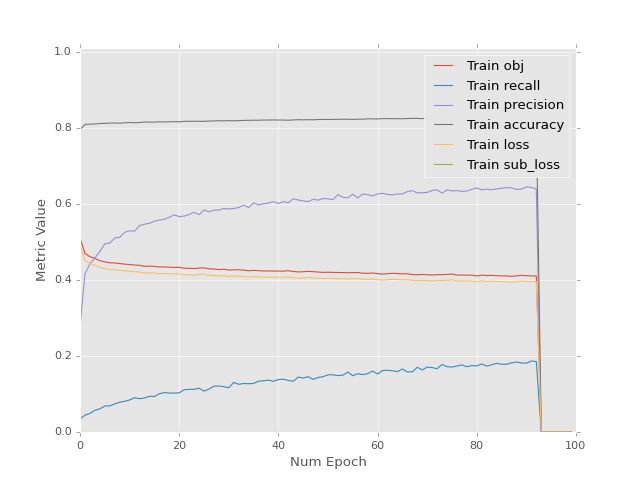

<IPython.core.display.Javascript object>


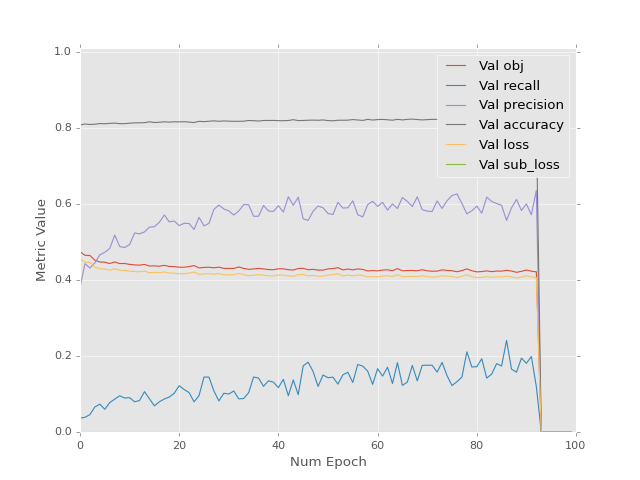

<IPython.core.display.Javascript object>


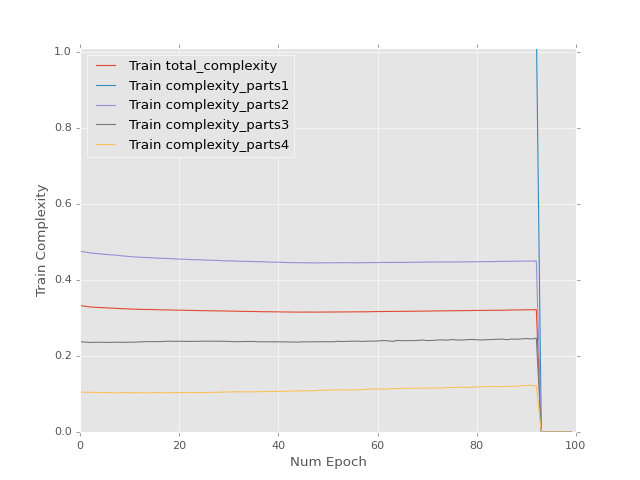

<IPython.core.display.Javascript object>


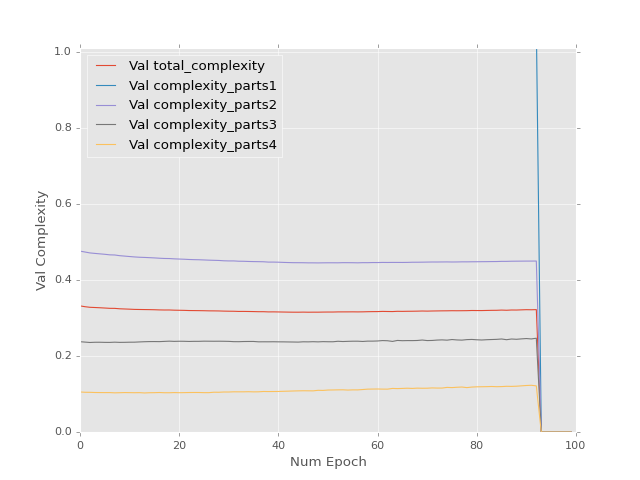

Epoch 1 of 100 took 149.025s
Epoch 2 of 100 took 149.791s
Epoch 3 of 100 took 149.302s
Epoch 4 of 100 took 149.551s
Epoch 5 of 100 took 149.898s
Epoch 6 of 100 took 149.570s
Epoch 7 of 100 took 149.262s
Epoch 8 of 100 took 149.491s
Epoch 9 of 100 took 149.623s
Epoch 10 of 100 took 149.370s
Epoch 11 of 100 took 149.440s
Epoch 12 of 100 took 149.197s
Epoch 13 of 100 took 149.165s
Epoch 14 of 100 took 149.814s
Epoch 15 of 100 took 149.411s
Epoch 16 of 100 took 149.692s
Epoch 17 of 100 took 149.286s
Epoch 18 of 100 took 149.323s
Epoch 19 of 100 took 149.225s
Epoch 20 of 100 took 149.275s
Epoch 21 of 100 took 149.286s
Epoch 22 of 100 took 149.120s
Epoch 23 of 100 took 149.821s
Epoch 24 of 100 took 149.147s
Epoch 25 of 100 took 149.499s
Epoch 26 of 100 took 149.426s
Epoch 27 of 100 took 149.274s
Epoch 28 of 100 took 149.334s
Epoch 29 of 100 took 149.722s
Epoch 30 of 100 took 149.433s
Epoch 31 of 100 took 149.406s
Epoch 32 of 100 took 149.195s
Epoch 33 of 100 took 149.254s
Epoch 34 of 100 too

In [ ]:
learn(network,
      X_y,
      watches=['obj',
               'recall',
               'precision',
               'accuracy',
               'loss',
               'sub_loss',
               'total_complexity',
               'complexity_parts'],
      num_epochs=100,
      batch_size=50)

/home/apanin/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


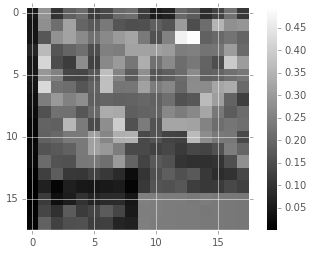

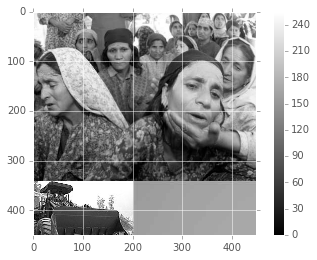

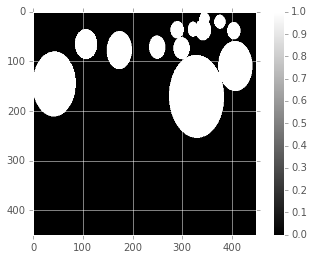

In [9]:
%matplotlib inline

plt.imshow(network.predict(X[0].reshape(1, 1, 450, 450))[0, 0], cmap=plt.cm.gray, interpolation='none')
plt.colorbar()
plt.show()
plt.imshow(X[0], cmap=plt.cm.gray)
plt.colorbar()
plt.show()
plt.imshow(y[0], cmap=plt.cm.gray)
plt.colorbar()
plt.show()

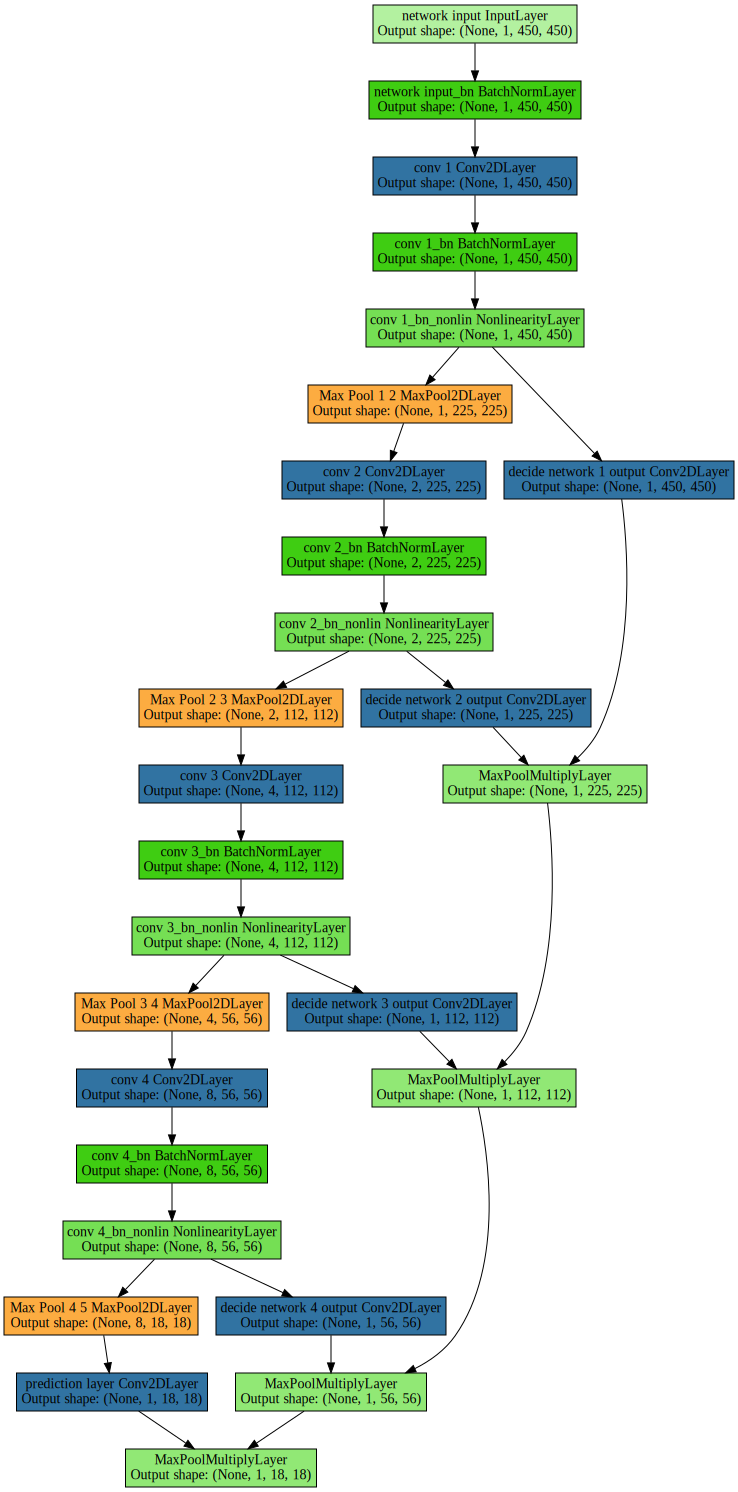

In [254]:
draw(network.output_layer)